# Reusing Pretrained Layers
**

**Suppose the Fashion MNIST dataset only contains eight classes. Someone built and trained a keras model.
and another man built a model of 2 classes of MNIST dataset so, he can use first pretrained model.

Let's split the fashion MNIst training set in two:
* `X_train_A` : all images of items except for sandals and shirts (classes 5 and 6).
* `X_train_B` : a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, Y_train_full), (X_test_full, Y_test_full) = fashion_mnist.load_data()

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
# split data in A and B
def split_dataset(X,Y):
    Y_5_or_6 = (Y==5) | (Y==6) #sandals or shirts
    Y_A = Y[~Y_5_or_6]
    Y_A[Y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    Y_B = (Y[Y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~Y_5_or_6], Y_A),
            (X[Y_5_or_6], Y_B))
(X_train_A, Y_train_A), (X_train_B, Y_train_B) = split_dataset(X_train_full, Y_train_full)
(X_test_A, Y_test_A), (X_test_B, Y_test_B) = split_dataset(X_test_full, Y_test_full)


In [5]:
X_train_A.shape

(48000, 28, 28)

In [6]:
X_train_B.shape

(12000, 28, 28)

In [7]:
X_test_A.shape

(8000, 28, 28)

In [8]:
X_test_B.shape

(2000, 28, 28)

In [9]:
Y_train_B[4]


1.0

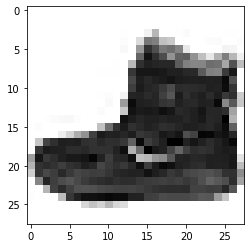

In [10]:
plt.imshow(X_train_A[0], cmap = plt.cm.binary) # (use cmap for remove extra color)
plt.show()

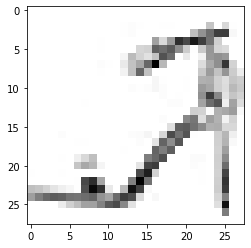

In [11]:
plt.imshow(X_train_B[0], cmap = plt.cm.binary) # (use cmap for remove extra color)
plt.show()

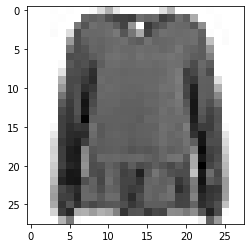

In [12]:
plt.imshow(X_train_B[4], cmap = plt.cm.binary) # (use cmap for remove extra color)
plt.show()

**Now first working on A model**

In [13]:
# data preprocessing
X_train_A = tf.keras.utils.normalize(X_train_A,axis=1)
X_test_A = tf.keras.utils.normalize(X_test_A,axis=1)

X_train_B = tf.keras.utils.normalize(X_train_B,axis=1)
X_test_B = tf.keras.utils.normalize(X_test_B,axis=1)

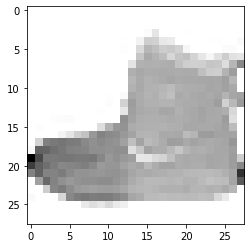

In [14]:
plt.imshow(X_train_A[0], cmap = plt.cm.binary) # (use cmap for remove extra color)
plt.show()

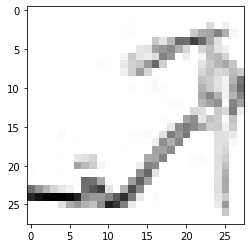

In [15]:
plt.imshow(X_train_B[0], cmap = plt.cm.binary) # (use cmap for remove extra color)
plt.show()

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300,100,50,50,50):
    model_A.add(keras.layers.Dense(n_hidden,kernel_initializer="lecun_normal",activation="selu"))
model_A.add(keras.layers.Dense(8,activation="softmax"))

In [18]:
model_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4

In [19]:
model_A.compile(loss="sparse_categorical_crossentropy", 
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=["accuracy"])

In [20]:
history_A= model_A.fit(X_train_A, Y_train_A, epochs=20,
                     validation_split= 0.2 )

Train on 38400 samples, validate on 9600 samples
Epoch 1/20
38400/38400 [==============================] - 6s 155us/sample - loss: 0.8511 - accuracy: 0.7650 - val_loss: 0.5230 - val_accuracy: 0.8375
Epoch 2/20
38400/38400 [==============================] - 3s 74us/sample - loss: 0.4573 - accuracy: 0.8502 - val_loss: 0.4050 - val_accuracy: 0.8608
Epoch 3/20
38400/38400 [==============================] - 3s 73us/sample - loss: 0.3820 - accuracy: 0.8694 - val_loss: 0.3573 - val_accuracy: 0.8708
Epoch 4/20
38400/38400 [==============================] - 3s 69us/sample - loss: 0.3456 - accuracy: 0.8797 - val_loss: 0.3370 - val_accuracy: 0.8772
Epoch 5/20
38400/38400 [==============================] - 3s 71us/sample - loss: 0.3237 - accuracy: 0.8865 - val_loss: 0.3152 - val_accuracy: 0.8870
Epoch 6/20
38400/38400 [==============================] - 3s 69us/sample - loss: 0.3092 - accuracy: 0.8915 - val_loss: 0.3074 - val_accuracy: 0.8901
Epoch 7/20
38400/38400 [==============================] 

**Model_A has 90% accuracy Now Save it**

In [21]:
model_A.save("my_model_A.h5")

**Now make Model_B**

In [22]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300,100,50,50,50):
    model_B.add(keras.layers.Dense(n_hidden,kernel_initializer="lecun_normal",activation="selu"))
model_B.add(keras.layers.Dense(1,activation="sigmoid"))

In [23]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [24]:
model_B.compile(loss="binary_crossentropy",
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=["accuracy"])

In [25]:
history_B=model_B.fit(X_train_B,Y_train_B,epochs=20,validation_split=0.2)

Train on 9600 samples, validate on 2400 samples
Epoch 1/20
9600/9600 [==============================] - 1s 148us/sample - loss: 0.2199 - accuracy: 0.9447 - val_loss: 0.0780 - val_accuracy: 0.9908
Epoch 2/20
9600/9600 [==============================] - 1s 74us/sample - loss: 0.0497 - accuracy: 0.9948 - val_loss: 0.0392 - val_accuracy: 0.9937
Epoch 3/20
9600/9600 [==============================] - 1s 77us/sample - loss: 0.0276 - accuracy: 0.9964 - val_loss: 0.0267 - val_accuracy: 0.9950
Epoch 4/20
9600/9600 [==============================] - 1s 82us/sample - loss: 0.0191 - accuracy: 0.9972 - val_loss: 0.0208 - val_accuracy: 0.9967
Epoch 5/20
9600/9600 [==============================] - 1s 77us/sample - loss: 0.0146 - accuracy: 0.9974 - val_loss: 0.0172 - val_accuracy: 0.9971
Epoch 6/20
9600/9600 [==============================] - 1s 78us/sample - loss: 0.0119 - accuracy: 0.9979 - val_loss: 0.0150 - val_accuracy: 0.9975
Epoch 7/20
9600/9600 [==============================] - 1s 76us/sampl

**Model_B give us 99% accuracy bcz model_B is small**<br>**For save our time we use Model_A to predict Model_B**

In [26]:
#load model_A
model_A_final = keras.models.load_model("my_model_A.h5")


In [27]:
model_A_clone = keras.models.clone_model(model_A_final)
model_A_clone.set_weights(model_A_final.get_weights())

In [28]:
#make new model with help of model B on A
model_B_on_A = keras.models.Sequential(model_A_final.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1,activation="sigmoid"))

In [29]:
# first freeze the reused layers 
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [30]:
model_B_on_A.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [31]:
history_1=model_B_on_A.fit(X_train_B,Y_train_B, epochs=4,
                          validation_split=0.2)

Train on 9600 samples, validate on 2400 samples
Epoch 1/4
9600/9600 [==============================] - 1s 122us/sample - loss: 0.2160 - accuracy: 0.9916 - val_loss: 0.1381 - val_accuracy: 0.9962
Epoch 2/4
9600/9600 [==============================] - 1s 116us/sample - loss: 0.1034 - accuracy: 0.9977 - val_loss: 0.0859 - val_accuracy: 0.9975
Epoch 3/4
9600/9600 [==============================] - 1s 96us/sample - loss: 0.0693 - accuracy: 0.9980 - val_loss: 0.0635 - val_accuracy: 0.9975
Epoch 4/4
9600/9600 [==============================] - 1s 106us/sample - loss: 0.0528 - accuracy: 0.9982 - val_loss: 0.0512 - val_accuracy: 0.9979


In [32]:
#unfreeze the reused layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history_2 = model_B_on_A.fit(X_train_B, Y_train_B, epochs=16,
                           validation_split=0.2)

Train on 9600 samples, validate on 2400 samples
Epoch 1/16
9600/9600 [==============================] - 1s 127us/sample - loss: 0.0302 - accuracy: 0.9983 - val_loss: 0.0242 - val_accuracy: 0.9975
Epoch 2/16
9600/9600 [==============================] - 1s 111us/sample - loss: 0.0167 - accuracy: 0.9984 - val_loss: 0.0172 - val_accuracy: 0.9979
Epoch 3/16
9600/9600 [==============================] - 1s 82us/sample - loss: 0.0120 - accuracy: 0.9985 - val_loss: 0.0141 - val_accuracy: 0.9979
Epoch 4/16
9600/9600 [==============================] - 1s 89us/sample - loss: 0.0096 - accuracy: 0.9985 - val_loss: 0.0122 - val_accuracy: 0.9979
Epoch 5/16
9600/9600 [==============================] - 1s 71us/sample - loss: 0.0080 - accuracy: 0.9990 - val_loss: 0.0110 - val_accuracy: 0.9979
Epoch 6/16
9600/9600 [==============================] - 1s 73us/sample - loss: 0.0070 - accuracy: 0.9991 - val_loss: 0.0101 - val_accuracy: 0.9979
Epoch 7/16
9600/9600 [==============================] - 1s 71us/samp

So, what's the final verdict?

In [33]:
model_B.evaluate(X_test_B, Y_test_B)

2000/2000 [==============================] - 0s 90us/sample - loss: 0.0029 - accuracy: 1.0000


[0.0029002437544986604, 1.0]

In [34]:
model_B_on_A.evaluate(X_test_B, Y_test_B)

2000/2000 [==============================] - 0s 82us/sample - loss: 0.0033 - accuracy: 0.9995


[0.0033477844186127186, 0.9995]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4!

In [35]:
(100 - 1.00) / (100 - 99.95)

1980.0000000001125